<img src="JFM-notebooks-logo.jpg" style="max-width:100%" />

### Imports

In [3]:
import sys, os
os.environ['NOWARNINGS'] = '1'
sys.path.append(os.path.join('Code'))
from load_data import load_data
from postprocessing.plotting import *
plotting_defaults()
plt.rcParams['figure.dpi'] = 150 # to adjust display size in notebook
ref, refsim, transient, varsim_list, enssim = load_data('Data')
textwidth = 5.31445

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from postprocessing.plotting import *
from postprocessing.superposition import *
viridis = plt.get_cmap('viridis')

### Generate figure

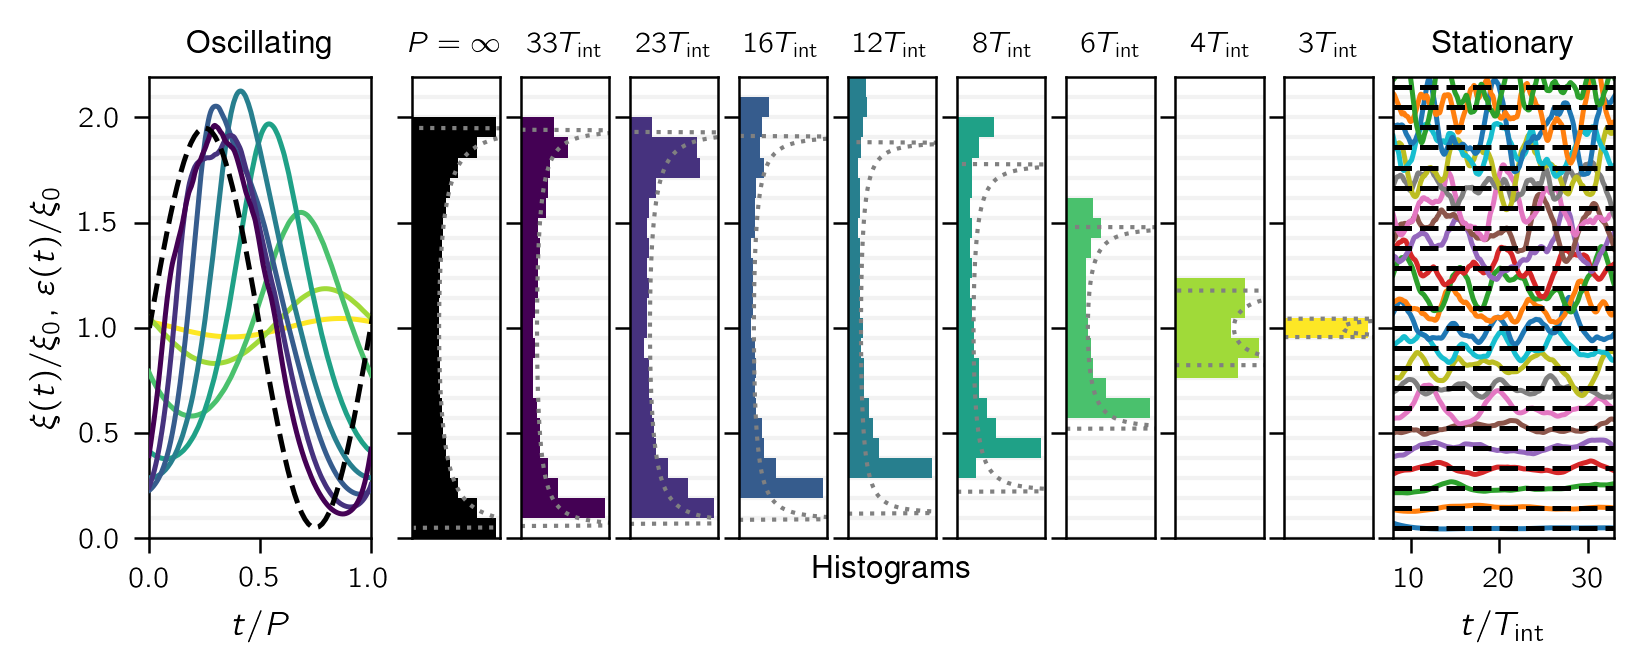

In [5]:
# select subset of oscillating simulations, only base ensemble, and bin number
varsim_list_short = list(reversed(varsim_list[5:]))
enssim512 = enssim.ensemble_list[0]
nbins = 256

# set up figure
fig, axs = plt.subplots(nrows=1, ncols=3+len(varsim_list_short),
    figsize=(textwidth, 0.4*textwidth), sharey=True,
    gridspec_kw={'width_ratios':[2.5, 1]+[1]*len(varsim_list_short)+[2.5,]})
fig.get_layout_engine().set(w_pad=0.01, wspace=0.01)
fig.get_layout_engine().set(rect=(0.0025, 0., 0.9975, 1.))

# compute ensemble weights
ens_bins = bins_from_seq(enssim512.get_injection_rates())
injweights = compute_injrate_weights(enssim512, varsim_list_short[0])
dissweights = compute_diss_weights(enssim512, varsim_list_short, transient,
                                   tbinno=nbins, tbinminsize=ref.tauK/2)

# add bin boundaries to every plot
for ax in axs:
    plt.sca(ax)
    for ebin in ens_bins:
        plt.hlines(ebin/ref.injrate, 0, 40, color=3*(0.950196,),
                   lw=1, zorder=-5)

# oscillating injection/dissipation rate plot
plt.sca(axs[0])
plt.gca().set_title('Oscillating', fontsize=8)
plt.plot(varsim_list[0].statistics['t']/varsim_list[0].get_period(),
         varsim_list[0].get_injection_rate(varsim_list[0].statistics['t'])/ref.injrate,
    c='black', ls='--', label='Injection rate', zorder=30)
plt.xlabel(r'$t/P$')
plt.ylabel(r'$\xi(t)/\xi_0,\, \varepsilon(t)/\xi_0$')
plt.xlim(0, 1)
plt.ylim(ens_bins[0]/ref.injrate, ens_bins[-1]/ref.injrate)

# injection rate histogram
plt.sca(axs[1])
plt.gca().set_title(r'$P = \infty$', fontsize=7)
plt.barh((ens_bins[1:] + ens_bins[:-1])/2/ref.injrate,
         injweights,
         (ens_bins[1] - ens_bins[0])/ref.injrate,
         color = 'black')
x, analhist = anal_injrate_histogram(ref.injrate, varsim_list[0].parameters['variation_strength']**2/2)
plt.plot(analhist*(ens_bins[1]-ens_bins[0]), x/ref.injrate, c='grey', ls=':', lw=1)
plt.xticks([])
plt.xlim(0, np.amax(injweights)*1.05)

# iterate over oscillating simulations
for vkey, varsim in enumerate(varsim_list_short):
    color = viridis(vkey/(len(varsim_list_short)-1))

    # add dissipation rate to leftmost axes
    plt.sca(axs[0])
    t_bins = varsim.get_tbins(nbins, minsize=ref.tauK/2)
    dt = t_bins[1] - t_bins[0]
    t_bincenters = (t_bins[1:] + t_bins[:-1])/2
    t_padded = np.concatenate(([t_bincenters[0]-dt], t_bincenters, [t_bincenters[-1]+dt]))
    diss = varsim.periodic_average(varsim.statistics['diss(t)'], t_bins, transient)
    diss_padded = np.concatenate(([diss[-1]], diss, [diss[0]]))
    plt.plot(t_padded/varsim.get_period(),
             diss_padded/ref.injrate,
             c=color, zorder=10-vkey)

    # dissipation rate histogram
    plt.sca(axs[2+vkey])
    plt.gca().set_title(r'${}T_\mathrm{{int}}$'.format(
        int(np.round(varsim.get_period()/ref.Tint))), fontsize=7)
    dissvariance = np.mean(diss**2) - np.mean(diss)**2
    x, analhist = anal_injrate_histogram(ref.injrate, dissvariance)
    plt.barh((ens_bins[1:] + ens_bins[:-1])/2/ref.injrate, dissweights[vkey], (ens_bins[1]-ens_bins[0])/ref.injrate,
        color = color)
    plt.plot(analhist*(ens_bins[1]-ens_bins[0]), x/ref.injrate, c='grey', ls=':', lw=1)
    plt.xticks([])
    plt.xlim(0, np.amax(dissweights[vkey])*1.05)
    if vkey == len(varsim_list_short)//2-1:
        plt.xlabel('Histograms')

# stationary injection rate plot
plt.sca(axs[-1])
for mem in enssim512.members:
    injrate = mem.parameters['injection_rate']
    t = mem.statistics['t']
    diss = mem.statistics['diss(t)']
    plt.plot(t/ref.Tint, diss/ref.injrate, zorder=-5)
    plt.axhline(injrate/ref.injrate, color='black', ls='--')
plt.xlim(t[t>transient][0]/ref.Tint, t[t>transient][0]/ref.Tint + 25)
plt.xlabel(r'$t/T_\mathrm{int}$')
plt.gca().set_title('Stationary', fontsize=8);